Re-implements [this](https://github.com/kmkolasinski/deep-learning-notes/blob/master/seminars/2019-03-Neural-Ordinary-Differential-Equations/1.Demo_spiral.ipynb).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from node.fix_grid import FixGridODESolver, FixGridODESolverWithTrajectory, rk4_step_fn
from node.base import reverse_mode_derivative

In [3]:
data_size = 1000
batch_time = 20  # this seems to works the best ...
n_iters = 3000
batch_size = 16

true_y0 = tf.constant([[2., 0.]])
true_A = tf.constant([[-0.1, 2.0], [-2.0, -0.1]])

In [4]:
def f(x, t):
    return tf.matmul(x**3, true_A)

In [5]:
ode_solver = FixGridODESolver(rk4_step_fn, data_size)
ode_solver_with_traj = FixGridODESolverWithTrajectory(rk4_step_fn, data_size)

In [6]:
_, true_y = ode_solver_with_traj(f, 0, 25, true_y0)
true_y = true_y.numpy().reshape([data_size, 2])
yN = ode_solver(f, 0, 25, true_y0)

(1000, 2)


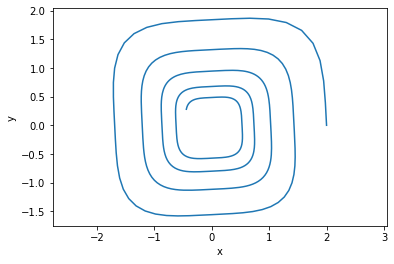

In [9]:
def plot_spiral(trajectories):
    for path in trajectories:
        print(path.shape)
        plt.plot(*path.T)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")

plot_spiral([true_y])

In [7]:
yN

<tf.Tensor: id=105909, shape=(1, 2), dtype=float32, numpy=array([[-0.4435913,  0.2795691]], dtype=float32)>